##  OCT Segmentation Results
Visualize results generated by the train_oct.py script.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import h5py
from functools import partial

import sys, time
import numpy as np
import pylab as plt
from scipy.io import loadmat


sys.path.append('../..')
import cnn_tools as ct
import train_oct
import postproc_oct as ppo

Using Theano backend.


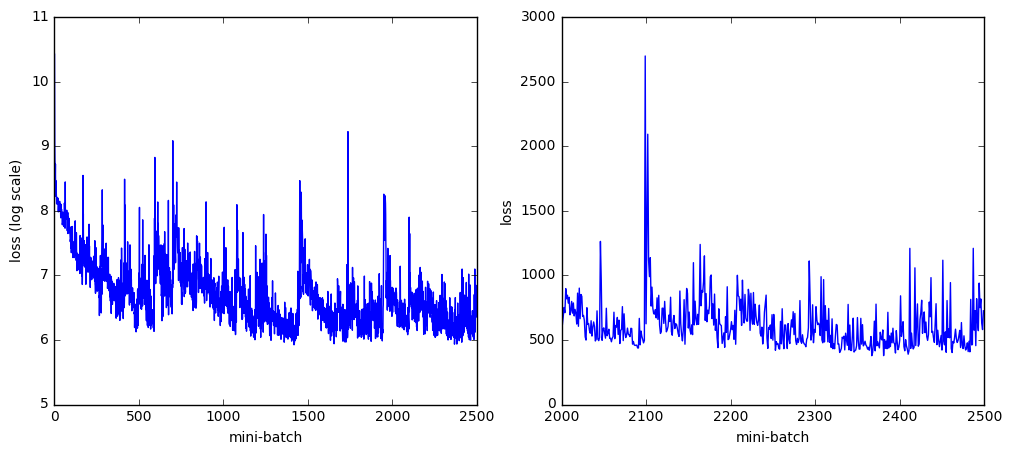

In [2]:
# Look at how training evolved
fn = 'oct_seg_fold0_valid_epoch0099.npz'

if os.path.exists(fn):
    f = np.load(fn)
    loss = f['s']
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(np.log(loss))
    plt.ylabel('loss (log scale)')
    plt.xlabel('mini-batch')
        
    plt.subplot(1,2,2)
    plt.plot(np.arange(len(loss)-500, len(loss)), loss[-500:])
    plt.xlabel('mini-batch')
    plt.ylabel('loss')

else:
    print('weight file %s not found' % fn)
    

In [3]:
# For now, just load results that were pre-computed on the cluster.
# My laptop is struggling to even deploy this stuff.

f = np.load('oct_seg_fold0_deploy_final.npz')

X = f['X']
Y = f['Y']
Y_hat = f['Y_hat']
test_slices = f['test_slices']
valid_slices = f['valid_slices']

train_slices = [x for x in range(50) if x not in test_slices and x not in valid_slices]

print('X shape:     ', X.shape)
print('Y shape:     ', Y.shape)
print('Y_hat shape: ', Y_hat.shape)
print('test slices are: ', test_slices)

X shape:      (50, 1, 512, 968)
Y shape:      (50, 1, 512, 968)
Y_hat shape:  (50, 512, 968)
test slices are:  [ 0  5 10 15 20 25 30 35 40 45]


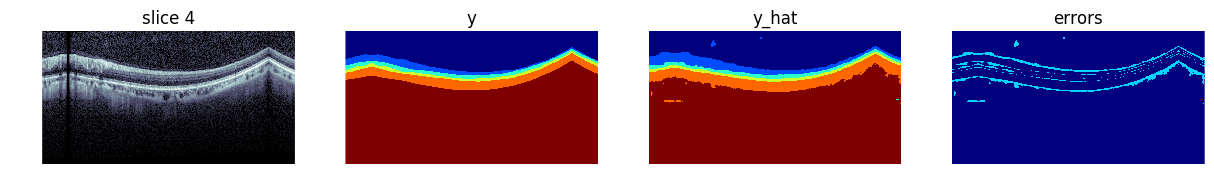

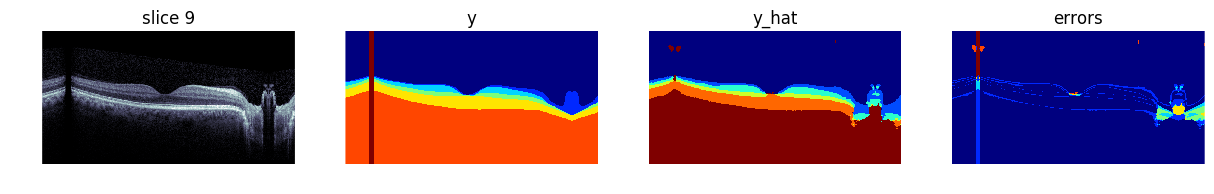

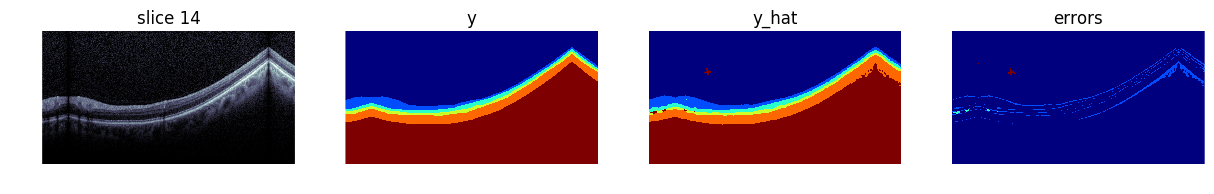

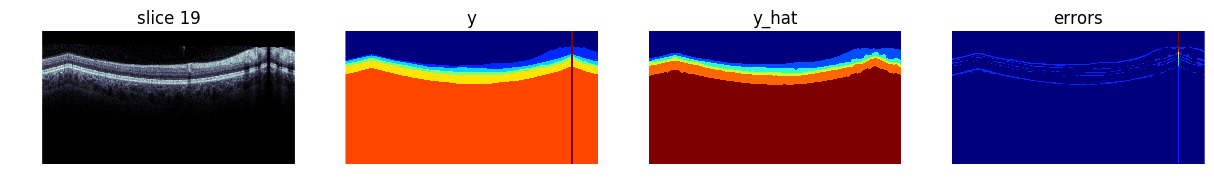

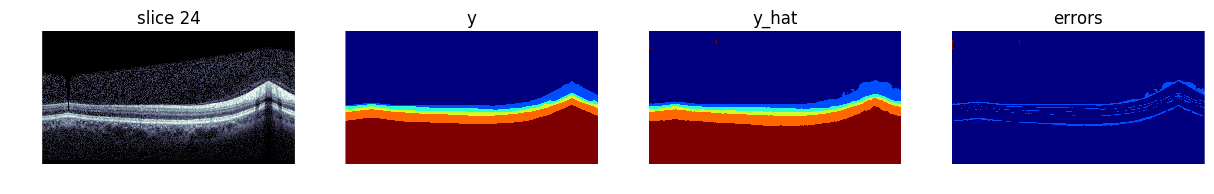

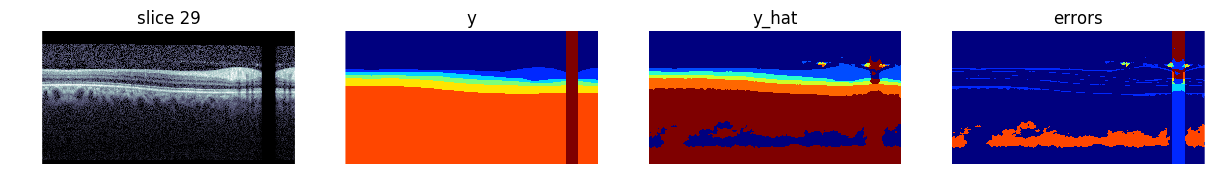

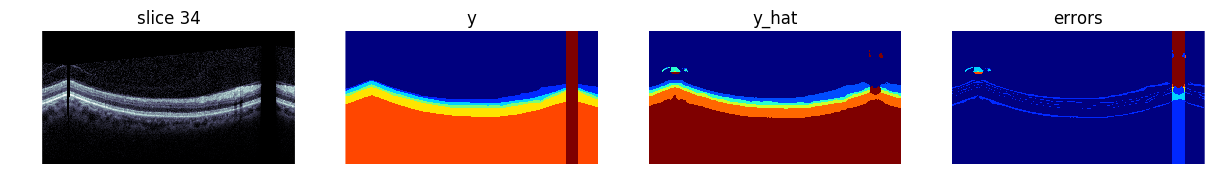

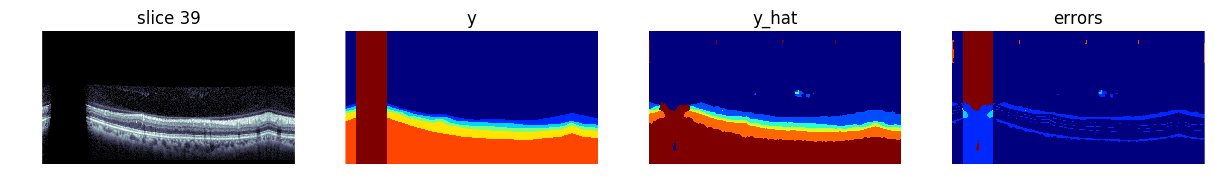

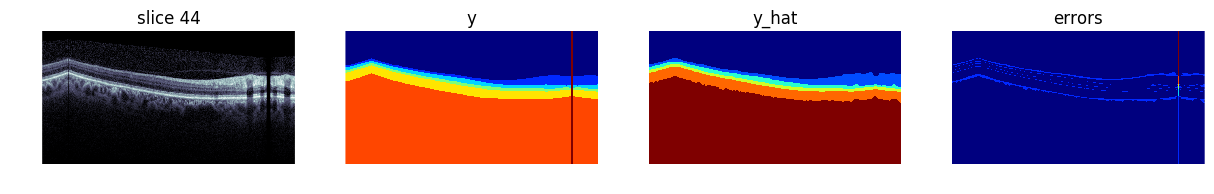

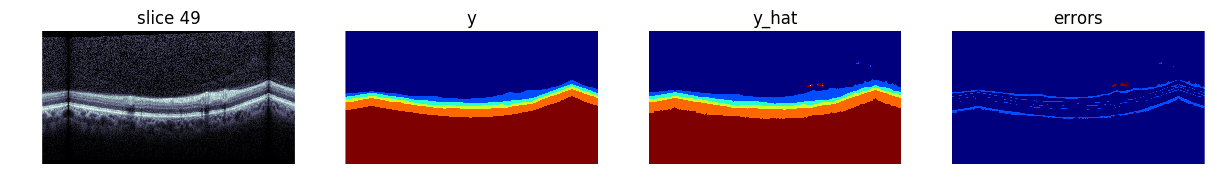

In [4]:
slices_to_view = valid_slices[:10]

for ts in slices_to_view:
    xi = np.squeeze(X[ts,...])
    yi = np.squeeze(Y[ts,...])
    yi_hat = Y_hat[ts,...]
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,4,1)
    plt.imshow(xi, interpolation='none', cmap='bone')
    plt.axis('off')
    plt.title('slice %d' % ts)
    
    plt.subplot(1,4,2)
    #plt.imshow(xi, interpolation='none', cmap='bone')
    plt.imshow(yi, interpolation='none', cmap='jet')
    plt.axis('off')
    plt.title('y')
    
    plt.subplot(1,4,3)
    plt.imshow(yi_hat, interpolation='none')
    plt.axis('off')
    plt.title('y_hat')
    
    plt.subplot(1,4,4)
    plt.imshow(np.abs(yi - yi_hat), interpolation='none')
    plt.axis('off')
    plt.title('errors')
    
    

(50, 1, 512, 748)
(50, 1, 512, 748)


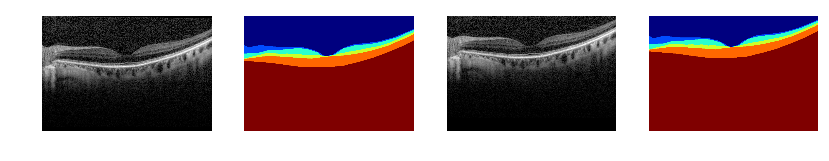

In [54]:
# here we are just visualizing the synthetic data augmentation.
print(X.shape)
print(Y.shape)

X_dy, Y_dy = train_oct.tian_shift_updown(X, Y)

idx = 0
plt.figure(figsize=(10,13))
plt.subplot(1,4,1)
plt.imshow(X[idx,0,...], interpolation=None, cmap='gray')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(Y[idx,0,...], interpolation=None, cmap='jet')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(X_dy[idx,0,...], interpolation=None, cmap='gray'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(Y_dy[idx,0,...], interpolation=None, cmap='jet'); plt.axis('off')

plt.show()

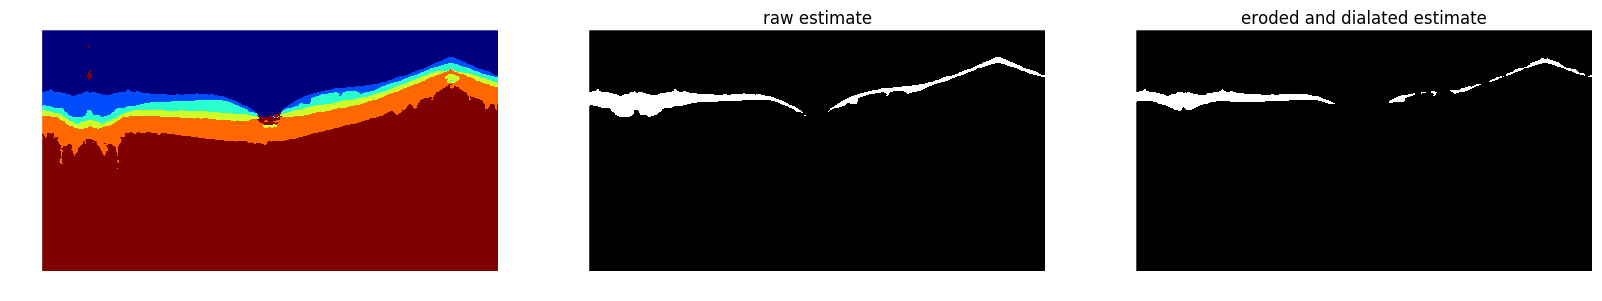

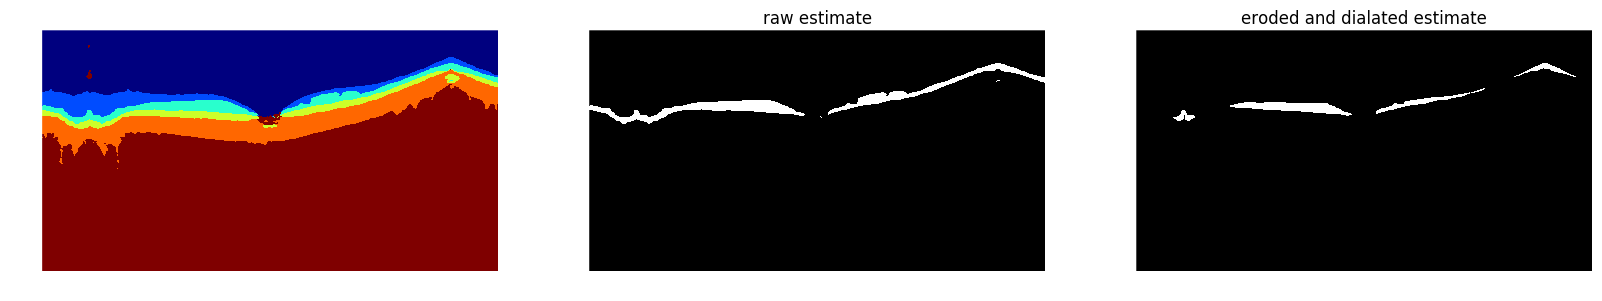

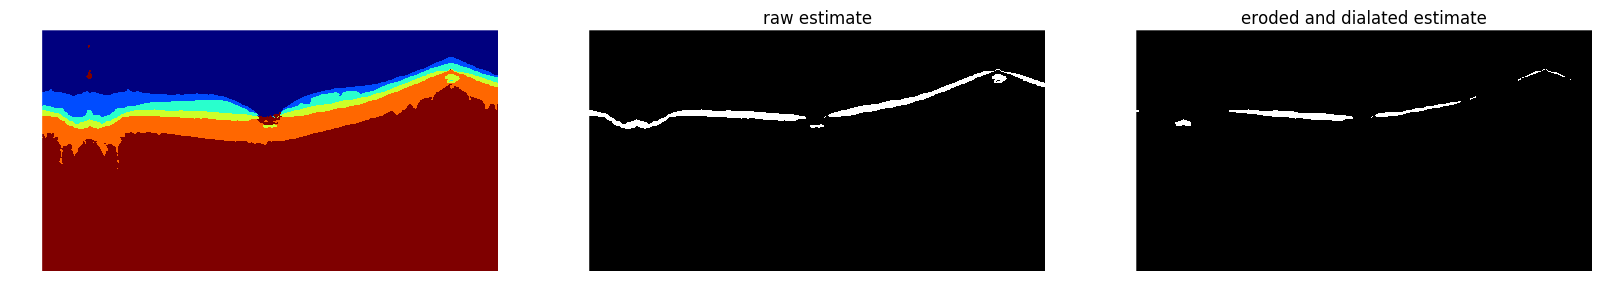

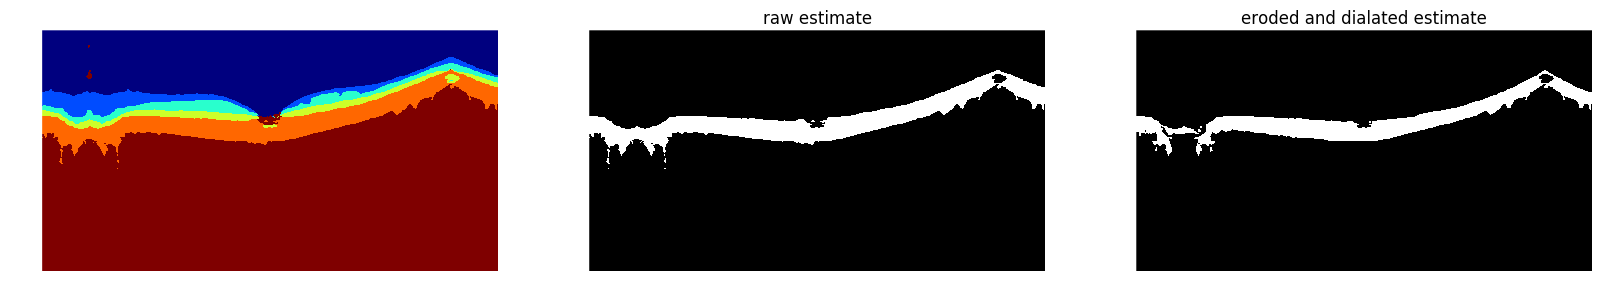

In [30]:
# experiment a bit with morphology operations

from skimage.morphology import opening

for yi in [1,2,3,4]:
    foo = Y_hat == yi
    bar = opening(foo)


    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.imshow(Y_hat[0,...], interpolation='none')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(foo[0,...], interpolation='none', cmap='bone')
    plt.axis('off')
    plt.title('raw estimate')

    plt.subplot(1,3,3)
    plt.imshow(bar[0,...], interpolation='none', cmap='bone')
    plt.axis('off')
    plt.title('eroded and dialated estimate')

    plt.show()

(512, 768)
(10, 512, 768)


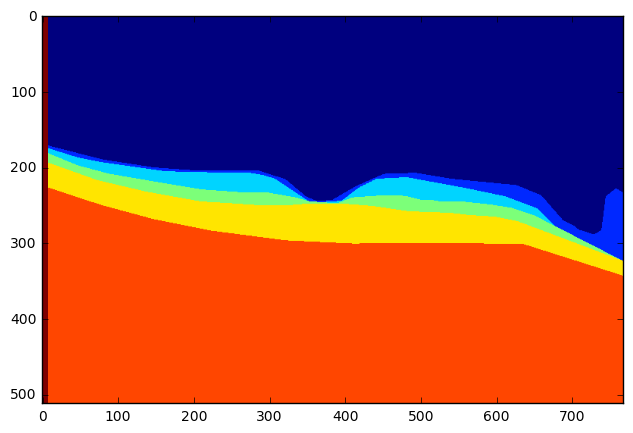

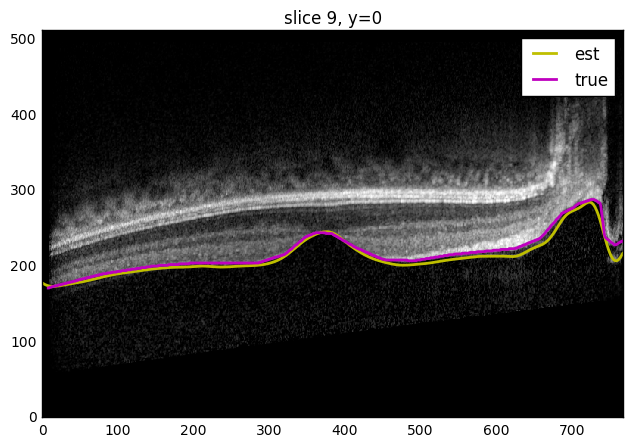

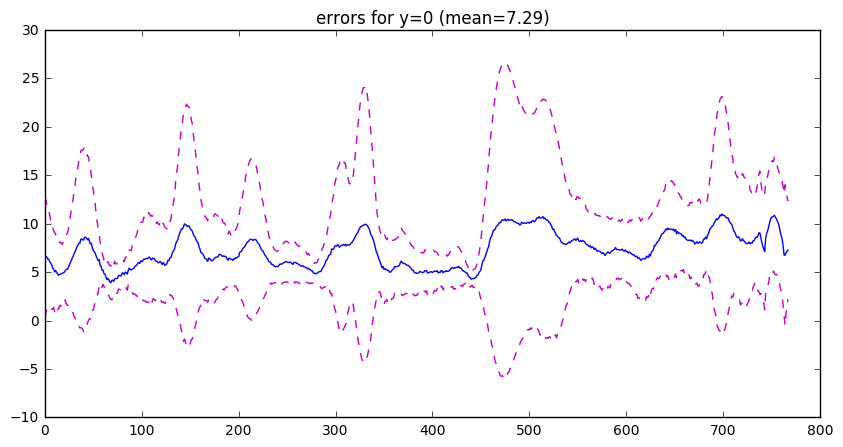

(512, 768)
(10, 512, 768)


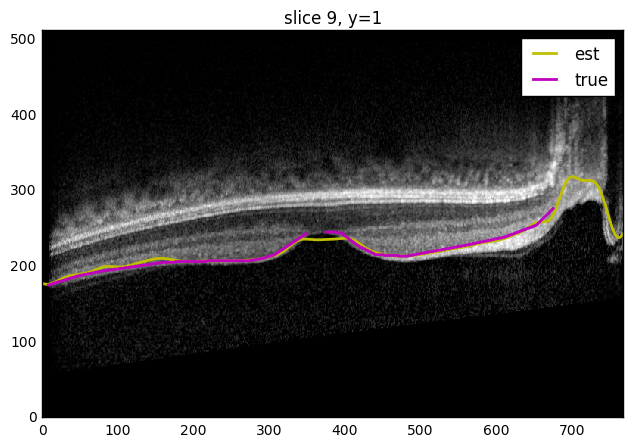

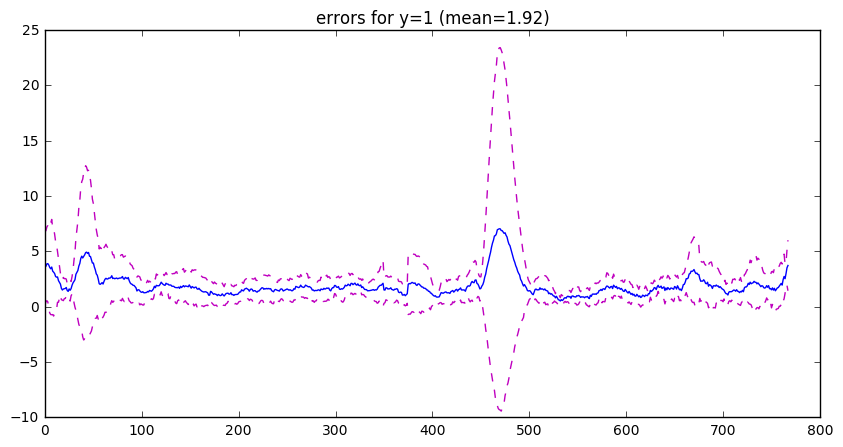

(512, 768)
(10, 512, 768)


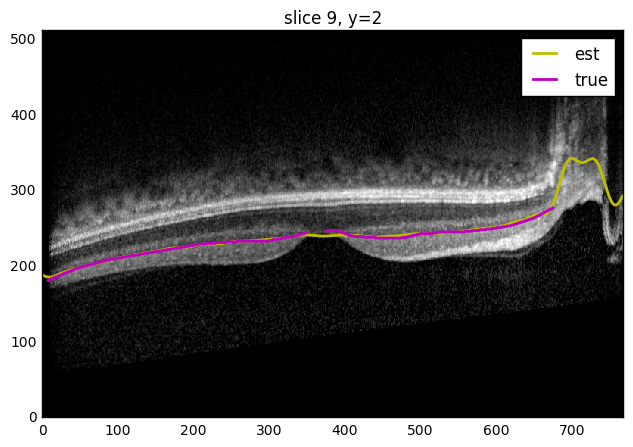

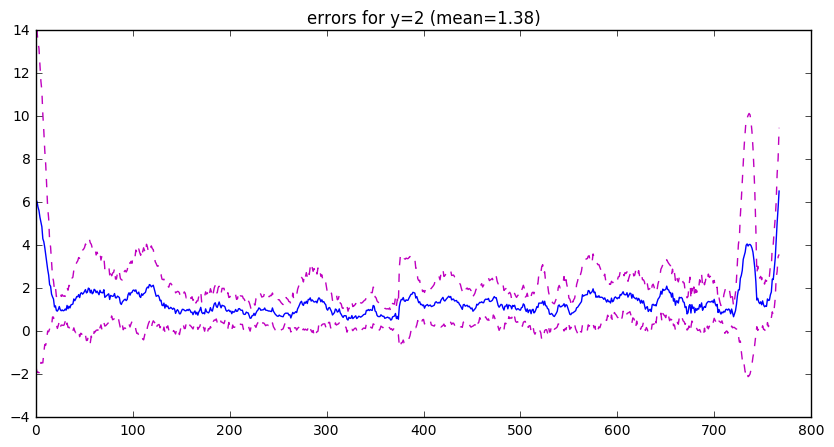

(512, 768)
(10, 512, 768)


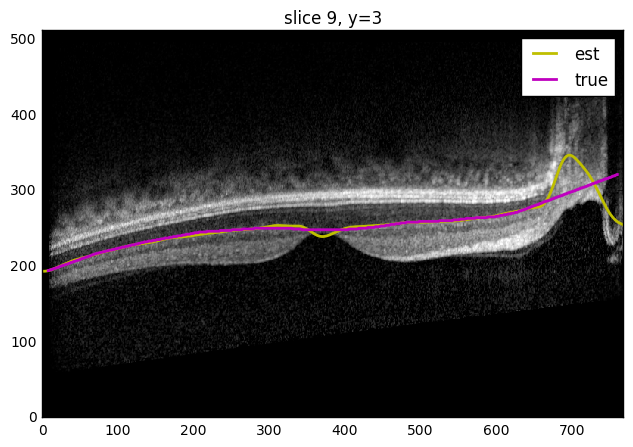

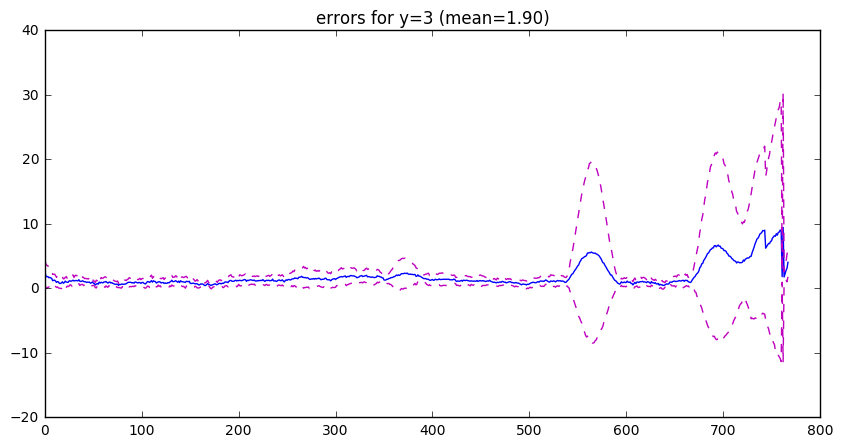

(512, 768)
(10, 512, 768)


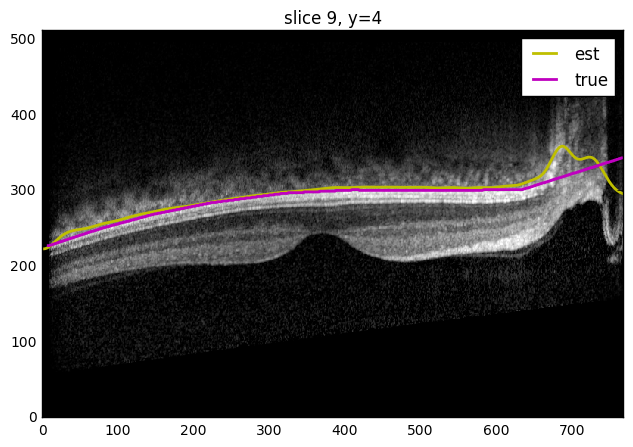

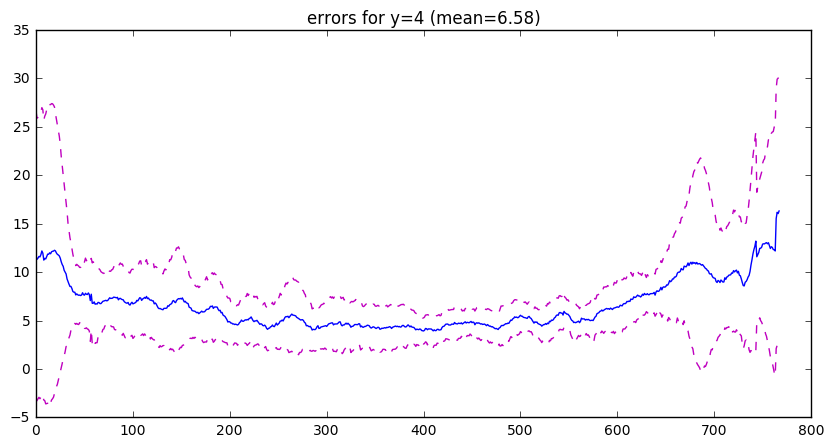

In [58]:
# here we experiment a bit with regression

Y_hat_v = np.squeeze(Y_hat[valid_slices,...])
Y_v = np.squeeze(Y[valid_slices,...])
show_idx = 1

# un-mirror
un_mirror = lambda M: M[...,100:-100]
Y_hat_v = un_mirror(Y_hat_v)
Y_v = un_mirror(Y_v)


# Look at true labels for one slice
plt.figure(figsize=(10,5))
plt.imshow(Y_v[show_idx,...])


for yi in [0,1,2,3,4]:
   
    # compute estimated and true boundaries
    B_hat = ppo.dense_to_boundary(Y_hat_v, yi, ppo.simple_boundary_regression_1d)
    B_true = ppo.dense_to_boundary(Y_v, yi, None)
    
    err_l1 = np.abs(B_hat - B_true)

    err_mu = np.nanmean(err_l1, axis=0)
    err_sigma = np.nanstd(err_l1, axis=0)
    
    # visualize result
    img = np.squeeze(X[valid_slices[show_idx],...])
    img = un_mirror(img)
    xv = np.arange(img.shape[1])
    print(img.shape)
    print(Y_hat_v.shape)
    
    plt.figure(figsize=(10,5))
    plt.imshow(img, interpolation='none', cmap='gray')
    plt.plot(xv, B_hat[show_idx,:], 'y-', linewidth=2, label='est')
    plt.plot(xv, B_true[show_idx,:], 'm-', linewidth=2, label='true')
    plt.xlim([0, img.shape[-1]])
    plt.ylim([0, img.shape[-2]])
    plt.title('slice %d, y=%d' % (valid_slices[show_idx], yi))
    plt.legend()
    
    # Show aggregate results (on validation data)
    plt.figure(figsize=(10,5))
    plt.plot(xv, err_mu, 'b-', 
             xv, err_mu+err_sigma, 'm--',
             xv, err_mu-err_sigma, 'm--')
    #plt.errorbar(np.arange(B_hat.shape[1]), err_mu, err_sigma)
    plt.title('errors for y=%d (mean=%0.2f)' % (yi, np.mean(err_mu)))
    
    plt.show()

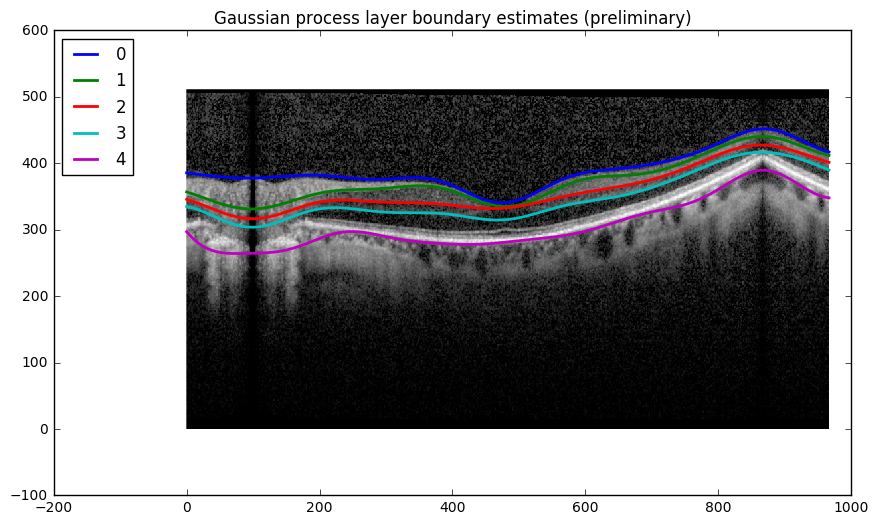

In [56]:
X0 = np.squeeze(X[0,...]);  X0 = np.flipud(X0)
x = np.arange(Y0.shape[1])

plt.figure(figsize=(15,6))
plt.imshow(X0, interpolation='none', cmap='gray')
for idx, m in enumerate(layers):
    y_mu, y_sigma = np.squeeze(m.predict(x[:,np.newaxis]))
    plt.plot(x, means[idx] + y_mu, label=idx, linewidth=2)

plt.legend(loc='upper left')
plt.title('Gaussian process layer boundary estimates (preliminary)')
plt.gca().invert_yaxis()
plt.show()
